In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -U albumentations
!pip install segmentation-models-pytorch
!pip install SimpleITK
!pip install torchmetrics
!pip install Medpy
!git clone https://github.com/deepmind/surface-distance.git
!pip install surface-distance/

In [ ]:
# Problem 1 data
# !wget "https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_Data.zip"
# !wget "https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip"
# !unzip "/content/ISBI2016_ISIC_Part3_Test_Data.zip" -d "/content/"
# !unzip "/content/ISBI2016_ISIC_Part3_Training_Data.zip" -d "/content/"

In [3]:
# import packages
from __future__ import print_function, division
import os
import math
import gc
import cv2
import time
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
import numpy as np
from torchvision import datasets, transforms, utils
from tqdm import tqdm
import torch.optim as optim 
from matplotlib import pyplot as plt
from skimage import io, transform
import pandas as pd
from torch.utils.data import Dataset, DataLoader, TensorDataset
import random
import albumentations as Augm
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow

In [ ]:
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi 

Thu Apr 13 13:48:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    35W /  70W |  12051MiB / 15360MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
train_DataRoot = "./ISBI2016_ISIC_Part3_Training_Data"
test_DataRoot = "./ISBI2016_ISIC_Part3_Test_Data"
if not os.path.exists(train_DataRoot):
    os.makedirs(train_DataRoot)
if not os.path.exists(test_DataRoot):
    os.makedirs(test_DataRoot)

# for filename in os.listdir("./ISBI2016_ISIC_Part3_Training_Data"):
#     file_path = os.path.join("./ISBI2016_ISIC_Part3_Training_Data", filename)
#     try:
#         if os.path.isfile(file_path) or os.path.islink(file_path):
#             os.unlink(file_path)
#         elif os.path.isdir(file_path):
#             shutil.rmtree(file_path)
#     except Exception as e:
#         print('Failed to delete %s. Reason: %s' % (file_path, e))

In [ ]:
if not os.path.exists("./train"):
    os.makedirs("./train")
    os.makedirs("./train/benign")
    os.makedirs("./train/malignant")
df = pd.read_csv("./ISBI2016_ISIC_Part3_Training_GroundTruth.csv")
shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/ISIC_0000000.jpg", "./train/benign/ISIC_0000000.jpg")
for i in range(len(df)):
    name, label = df["ISIC_0000000"][i], df["benign"][i]
    shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/"+name+".jpg", "./train/"+label+"/"+name+".jpg")
    
      
if not os.path.exists("./test"):
    os.makedirs("./test")
    os.makedirs("./test/benign")
    os.makedirs("./test/malignant")
df = pd.read_csv("./ISBI2016_ISIC_Part3_Test_GroundTruth.csv")
shutil.copy("./ISBI2016_ISIC_Part3_Test_Data/ISIC_0000003.jpg", "./test/benign/ISIC_0000003.jpg")
for i in range(len(df)):
    name, label = df["ISIC_0000003"][i], df["0.0"][i]
    label = "benign" if label == 0 else "malignant"
    shutil.copy("./ISBI2016_ISIC_Part3_Test_Data/"+name+".jpg", "./test/"+label+"/"+name+".jpg")

In [ ]:
## Load data
root_train = './train'
root_test = './test'
TRANSFORM = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=0.5,
        std=0.5
    )
])

def get_train_test_set(batch_size=16, transform=TRANSFORM, train_dataset=None, 
                       test_dataset=None, noAugm=True, root_train=root_train, root_test=root_test):
    if noAugm:
        train_dataset = datasets.ImageFolder(root_train, transform=transform)
        test_dataset = datasets.ImageFolder(root_test, transform=transform)
        loader_train = torch.utils.data.DataLoader(
            dataset=train_dataset,
            batch_size=batch_size,
            shuffle=True
            )
        
        loader_test = torch.utils.data.DataLoader(
            dataset=test_dataset,
            batch_size=batch_size,
            shuffle=False
            )
    else:
        # print("before concat")
        # print(type(train_dataset))
        # print(len(train_dataset))
        Augm_train_subset = []
        Augm_test_subset = []
        UnAugm_train_dataset = datasets.ImageFolder(root_train, transform=transform)
        UnAugm_test_dataset = datasets.ImageFolder(root_test, transform=transform)
        ## Half Augm & Half UnAugm
        n_UnAugm_train = int(0.5 * len(UnAugm_train_dataset)) ## 900 / 2
        n_UnAugm_test = 199
        n_Augm_train = int(n_UnAugm_train/3)                  ## 450 / 3
        n_Augm_test = 60                                      ## 60 * 3
        # print("n_UnAugm_train", n_UnAugm_train)
        # print("n_UnAugm_test", n_UnAugm_test)
        # print("n_Augm_train", n_Augm_train)
        # print("n_Augm_test", n_Augm_test)
        
        ## split & combine train dataset
        UnAugm_train_subset = torch.utils.data.Subset(UnAugm_train_dataset, range(n_UnAugm_train))
        for dataset in train_dataset:
            Augm_train_subset.append(torch.utils.data.Subset(dataset, range(n_Augm_train)))
        #     print("len Augm_train_subset", len(Augm_train_subset[-1]))
        # print("len UnAugm_train_subset", len(UnAugm_train_subset))
        train_dataset = torch.utils.data.ConcatDataset([UnAugm_train_subset, Augm_train_subset[0],
                                                        Augm_train_subset[1], Augm_train_subset[2]])
        ## split & combine test dataset
        UnAugm_test_subset = torch.utils.data.Subset(UnAugm_test_dataset, range(n_UnAugm_test))
        for dataset in test_dataset:
            Augm_test_subset.append(torch.utils.data.Subset(dataset, range(n_Augm_test)))
        test_dataset = torch.utils.data.ConcatDataset([UnAugm_test_subset, Augm_test_subset[0],
                                                        Augm_test_subset[1], Augm_test_subset[2]])
        # print("after concat")
        # print(type(train_dataset))
        # print(len(train_dataset))


        ## data loader
        loader_train = torch.utils.data.DataLoader(
            dataset=train_dataset,
            batch_size=batch_size,
            shuffle=True,
            pin_memory=True
            )
        loader_test = torch.utils.data.DataLoader(
            dataset=test_dataset,
            batch_size=batch_size,
            shuffle=True,
            pin_memory=True
            )
    return loader_train, loader_test

In [ ]:
train_loader, test_loader = get_train_test_set()
dataloader_iter = iter(train_loader)
batch_data = next(dataloader_iter)
print(len(batch_data))
img, label = batch_data
print(img.shape)
print(label)

dataloader_iter = iter(test_loader)
batch_data = next(dataloader_iter)
print(len(batch_data))
img, label = batch_data
print(img.shape)
print(label)

2
torch.Size([16, 3, 224, 224])
tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1])
2
torch.Size([16, 3, 224, 224])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
def test(model, test_loader, Loss, noAugm=True):
    model.eval()

    correct = 0
    test_loss = 0
    total = 0
    label_concat = np.arange(0)
    pred_concat = np.arange(0)
    for i, data in tqdm(enumerate(test_loader)):
        inputs, labels = data
        if not noAugm:
            inputs = inputs.to(torch.float64)
            inputs = inputs.type(torch.cuda.FloatTensor)
            labels = labels.to(torch.float64)
            labels = labels.type(torch.cuda.LongTensor)
            # print(inputs.is_cuda)
            # print(labels.is_cuda)
            # print(inputs.dtype)
        else:
            inputs = inputs.cuda()
            labels = labels.cuda()
        outputs = model(inputs)

        loss = Loss(outputs, labels)
        pred = torch.argmax(outputs, dim=1)
        correct += torch.sum(pred == labels).item()
        pred_np = np.array(pred.cpu()).astype('float64')
        pred_concat = np.concatenate((pred_concat, pred_np))
        labels_np = np.array(labels.cpu()).astype('float64')
        label_concat = np.concatenate((label_concat, labels_np))
        test_loss += loss.item()
        total += labels.size(0)

    test_loss = test_loss / len(test_loader)
    acc_test = 100 * correct / total
    AUC = roc_auc_score(label_concat, pred_concat)
    return test_loss, acc_test, AUC

def train(model, train_loader, optimizer, Loss, noAugm=True):
    model.train()
    
    correct = 0
    total = 0
    train_loss = 0
    for i, data in tqdm(enumerate(train_loader)):
        inputs, labels = data
        if not noAugm:
            inputs = inputs.to(torch.float64)
            inputs = inputs.type(torch.cuda.FloatTensor)
            labels = labels.to(torch.float64)
            labels = labels.type(torch.cuda.LongTensor)
            # print(inputs.is_cuda)
            # print(labels.is_cuda)
            # print(inputs.dtype)
        else:
            inputs = inputs.cuda()
            labels = labels.cuda()
        outputs = model(inputs)
        
        optimizer.zero_grad()
        
        loss = Loss(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, prediction = torch.max(outputs.data, 1)  
        total += labels.size(0)
        correct += (prediction == labels).sum().item()
    train_loss = train_loss / len(train_loader)
    train_acc = 100 * correct / total
    return model, train_loss, train_acc
    
def conv3x3(in_planes, out_planes, stride=1):
  return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                    padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
    
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, use_fc=False, dropout=None):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.use_fc = use_fc
        self.use_dropout = True if dropout else False
        if self.use_fc:
            print('Using fc.')
            self.fc_add = nn.Linear(512*block.expansion, 512)
        if self.use_dropout:
            print('Using dropout.')
            self.dropout = nn.Dropout(p=dropout)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x, *args):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.mean(dim=(-2, -1))
        x = x.view(x.size(0), -1)
        if self.use_fc:
            x = F.relu(self.fc_add(x))
        if self.use_dropout:
            x = self.dropout(x)
        return x
Resnet50 = ResNet(Bottleneck, [3, 4, 6, 3], dropout=None)

In [ ]:
## load pretrained ResNet
from torchvision.models import resnet50

pre_trained = resnet50(weights="IMAGENET1K_V2").state_dict()
new_weights = {k: pre_trained[k] for k in Resnet50.state_dict()}
Resnet50.load_state_dict(new_weights)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
class Model(nn.Module):
  def __init__(self, encoder, num_classes=10):
    super(Model, self).__init__()
    self.encoder = encoder
    self.classifier = nn.Linear(2048, num_classes)
  def forward(self, x):
    x = self.encoder(x)
    x = self.classifier(x)
    return x
model = Model(Resnet50, 10)

In [ ]:
## train model
total_epoch = 10
train_losses = []
val_losses = []
train_accs = []
val_accs = []
AUC_list = []
time_total = 0

model = model.cuda()
lr = 1e-3
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
Loss = nn.CrossEntropyLoss()
        
for epoch in range(total_epoch):
    print(" -- Epoch {}/{}".format(epoch + 1, total_epoch))
    ## clear gpu cache
    gc.collect()
    torch.cuda.empty_cache()

    time_start = time.time()
    model, train_loss, train_acc = train(model, train_loader, optimizer, Loss)
    time_end = time.time()
        
    train_losses.append(train_loss)
    train_accs.append(train_acc)
        
    time_duration = round(time_end - time_start, 2)
    time_total += time_duration
    
    ## clear gpu cache
    gc.collect()
    torch.cuda.empty_cache()

    ## test model
    test_loss, test_acc, auc = test(model, test_loader, Loss)
    AUC_list.append(auc)
    val_losses.append(test_loss)
    val_accs.append(test_acc)
    print("Train Loss {:.4f}, Train Accuracy {:.4f}%, Test Loss {:.4f}, Test Accuracy {:.4f}%".format(
        train_loss,
        train_acc,
        test_loss,
        test_acc
    ))

 -- Epoch 1/10


57it [01:14,  1.31s/it]
24it [00:23,  1.03it/s]


Train Loss 0.9327, Train Accuracy 75.4444%, Test Loss 0.5624, Test Accuracy 80.2111%
 -- Epoch 2/10


57it [01:05,  1.15s/it]
24it [00:23,  1.03it/s]


Train Loss 0.4640, Train Accuracy 81.2222%, Test Loss 0.4931, Test Accuracy 81.0026%
 -- Epoch 3/10


57it [01:04,  1.13s/it]
24it [00:23,  1.02it/s]


Train Loss 0.4009, Train Accuracy 83.1111%, Test Loss 0.4594, Test Accuracy 82.3219%
 -- Epoch 4/10


57it [01:04,  1.14s/it]
24it [00:22,  1.08it/s]


Train Loss 0.3966, Train Accuracy 83.4444%, Test Loss 0.4334, Test Accuracy 83.3773%
 -- Epoch 5/10


57it [01:04,  1.13s/it]
24it [00:22,  1.05it/s]


Train Loss 0.3513, Train Accuracy 85.0000%, Test Loss 0.4177, Test Accuracy 83.3773%
 -- Epoch 6/10


57it [01:04,  1.14s/it]
24it [00:25,  1.08s/it]


Train Loss 0.3236, Train Accuracy 85.0000%, Test Loss 0.4243, Test Accuracy 82.0580%
 -- Epoch 7/10


57it [01:04,  1.13s/it]
24it [00:22,  1.05it/s]


Train Loss 0.2971, Train Accuracy 87.4444%, Test Loss 0.4051, Test Accuracy 86.5435%
 -- Epoch 8/10


57it [01:05,  1.15s/it]
24it [00:23,  1.02it/s]


Train Loss 0.2785, Train Accuracy 88.4444%, Test Loss 0.4122, Test Accuracy 83.9050%
 -- Epoch 9/10


57it [01:05,  1.15s/it]
24it [00:22,  1.05it/s]


Train Loss 0.2361, Train Accuracy 89.7778%, Test Loss 0.3913, Test Accuracy 87.0712%
 -- Epoch 10/10


57it [01:04,  1.14s/it]
24it [00:22,  1.06it/s]

Train Loss 0.2151, Train Accuracy 91.3333%, Test Loss 0.4691, Test Accuracy 84.9604%


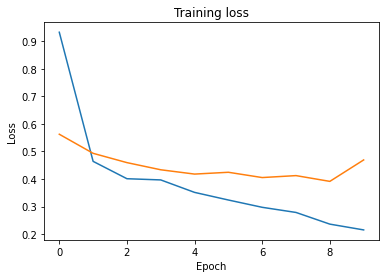

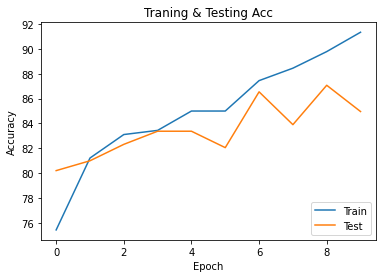

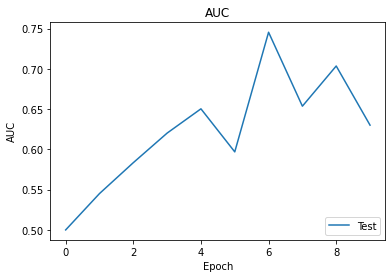

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.figure()

plt.title("Traning & Testing Acc")
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Test")
plt.legend(loc="lower right")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

plt.title("AUC")
plt.plot(AUC_list, label="Test")
plt.legend(loc="lower right")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.show()

In [ ]:
class AugmDataSet():
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "malignant":
            label = 1.0
        else:
            label = 0.0
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [ ]:
BenignTrain_direc = "/content/train/benign/"
MaligTrain_direc = "/content/train/malignant/"
BenignTest_direc = "/content/test/benign/"
MaligTest_direc = "/content/test/malignant"

BenignTrain_filepaths = sorted([os.path.join(BenignTrain_direc, f) for f in os.listdir(BenignTrain_direc)])
MaligTrain_filepaths = sorted([os.path.join(MaligTrain_direc, f) for f in os.listdir(MaligTrain_direc)])
images_filepaths = [*BenignTrain_filepaths, *MaligTrain_filepaths]
TrainImages_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

BenignTest_filepaths = sorted([os.path.join(BenignTest_direc, f) for f in os.listdir(BenignTest_direc)])
MaligTest_filepaths = sorted([os.path.join(MaligTest_direc, f) for f in os.listdir(MaligTest_direc)])
images_filepaths = [*BenignTest_filepaths, *MaligTest_filepaths]
TestImages_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(TrainImages_filepaths)
random.shuffle(TestImages_filepaths)
print(len(TrainImages_filepaths), len(TestImages_filepaths))

In [ ]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
display_image_grid(TestImages_filepaths[:10])

In [ ]:
# Flipping
GEO = Augm.Compose([
    Augm.augmentations.geometric.resize.Resize(224, 224),
    Augm.RandomCrop(width=224, height=224),
    Augm.HorizontalFlip(p=1),
    Augm.RandomBrightnessContrast(p=0.1),
    ToTensorV2()
])
GEO_train_dataset = AugmDataSet(images_filepaths=TrainImages_filepaths, transform=GEO)
GEO_test_dataset = AugmDataSet(images_filepaths=TestImages_filepaths, transform=GEO)
# Color distortion
COL = Augm.Compose([
    Augm.augmentations.geometric.resize.Resize(224, 224),
    Augm.RandomCrop(width=224, height=224),
    Augm.augmentations.transforms.ColorJitter(),
    Augm.RandomBrightnessContrast(p=0.1),
    ToTensorV2()
])
COL_train_dataset = AugmDataSet(images_filepaths=TrainImages_filepaths, transform=COL)
COL_test_dataset = AugmDataSet(images_filepaths=TestImages_filepaths, transform=COL)
# PCA
PCA = Augm.Compose([
    Augm.augmentations.geometric.resize.Resize(224, 224),
    Augm.RandomCrop(width=224, height=224),
    Augm.augmentations.transforms.FancyPCA(),
    Augm.RandomBrightnessContrast(p=0.1),
    ToTensorV2()
])
PCA_train_dataset = AugmDataSet(images_filepaths=TrainImages_filepaths, transform=PCA)
PCA_test_dataset = AugmDataSet(images_filepaths=TestImages_filepaths, transform=PCA)

train_loader, test_loader = get_train_test_set(train_dataset=[GEO_train_dataset,COL_train_dataset,PCA_train_dataset],
                                               test_dataset=[GEO_test_dataset,COL_test_dataset,PCA_test_dataset], noAugm=False)
print(type(train_loader))

## train model
total_epoch = 10
train_losses = []
val_losses = []
train_accs = []
val_accs = []
AUC_list = []
time_total = 0

model = model.cuda()
lr = 1e-3
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
Loss = nn.CrossEntropyLoss()
        
for epoch in range(total_epoch):
    print(" -- Epoch {}/{}".format(epoch + 1, total_epoch))
    ## clear gpu cache
    gc.collect()
    torch.cuda.empty_cache()

    time_start = time.time()
    model, train_loss, train_acc = train(model, train_loader, optimizer, Loss, noAugm=False)
    time_end = time.time()
        
    train_losses.append(train_loss)
    train_accs.append(train_acc)
        
    time_duration = round(time_end - time_start, 2)
    time_total += time_duration
    
    ## clear gpu cache
    gc.collect()
    torch.cuda.empty_cache()

    ## test model
    test_loss, test_acc, auc = test(model, test_loader, Loss, noAugm=False)
    AUC_list.append(auc)
    val_losses.append(test_loss)
    val_accs.append(test_acc)
    print("Train Loss {:.4f}, Train Accuracy {:.4f}%, Test Loss {:.4f}, Test Accuracy {:.4f}%".format(
        train_loss,
        train_acc,
        test_loss,
        test_acc
    ))

In [ ]:
GEO = Augm.Compose([
    Augm.augmentations.geometric.resize.Resize(244, 244),
    Augm.RandomCrop(width=224, height=224),
    Augm.HorizontalFlip(p=1),
    Augm.RandomBrightnessContrast(p=0.1),
])

# Show example
image = mpimg.imread("/content/ISBI2016_ISIC_Part3_Test_Data/ISIC_0000003.jpg")
# Augment an image
transformed = GEO(image=image)
transformed_image = transformed["image"]

plt.figure()
imgplot = plt.imshow(transformed_image)
plt.show(imgplot)

plt.figure()
imgplot1 = plt.imshow(image)
plt.show(imgplot1)

In [ ]:
# Color distortion
color_transform = Augm.Compose([
    Augm.augmentations.geometric.resize.Resize(244, 244),
    Augm.RandomCrop(width=224, height=224),
    Augm.augmentations.transforms.ColorJitter(),
    Augm.RandomBrightnessContrast(p=0.1),
])

image = mpimg.imread("/content/ISBI2016_ISIC_Part3_Test_Data/ISIC_0000003.jpg")

# Augment an image
transformed = color_transform(image=image)
transformed_image = transformed["image"]

plt.figure()
imgplot = plt.imshow(transformed_image)
plt.show(imgplot)

plt.figure()
imgplot1 = plt.imshow(image)
plt.show(imgplot1)

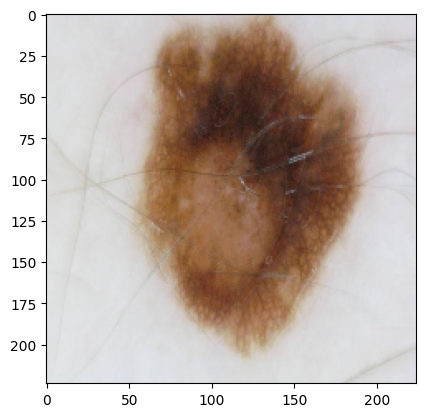

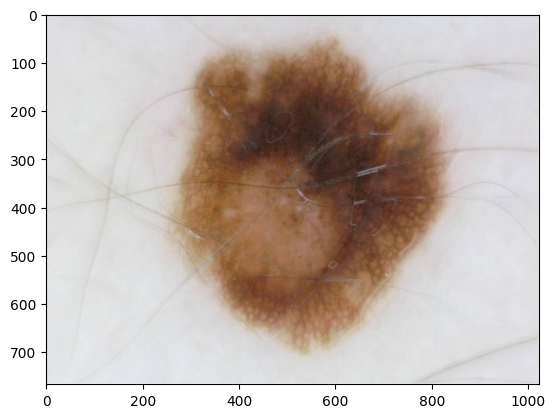

In [ ]:
# PCA
PCA_transform = Augm.Compose([
    Augm.augmentations.geometric.resize.Resize(244, 244),
    Augm.RandomCrop(width=224, height=224),
    Augm.augmentations.transforms.FancyPCA(),
    Augm.RandomBrightnessContrast(p=0.1),
])

image = mpimg.imread("/content/ISBI2016_ISIC_Part3_Test_Data/ISIC_0000003.jpg")

# Augment an image
transformed = PCA_transform(image=image)
transformed_image = transformed["image"]

plt.figure()
imgplot = plt.imshow(transformed_image)
plt.show(imgplot)

plt.figure()
imgplot1 = plt.imshow(image)
plt.show(imgplot1)

In [ ]:
# Problem 2 data
!unzip "/content/gdrive/MyDrive/ELEC4010N/HW2/kaggle_3m.zip" -d "/content/"

In [5]:
from pylab import *
from os import walk
from ast import In
from google.colab.patches import cv2_imshow
from torch.nn.modules.loss import _Loss
import segmentation_models_pytorch as smp
from medpy import metric
import surface_distance as surfdist
from torchmetrics.classification import BinaryJaccardIndex

All_DataRoot = "/content/kaggle_3m/"
train_DataRoot = "./MRI_TrianData"
test_DataRoot = "./MRI_TestData"
trainData_namelist = []
testData_namelist = []
train_csv = pd.read_csv("/content/kaggle_3m/Training_data.csv")
test_csv = pd.read_csv("/content/kaggle_3m/Testing_data.csv")

if not os.path.exists(train_DataRoot):
    os.makedirs(train_DataRoot)
if not os.path.exists(test_DataRoot):
    os.makedirs(test_DataRoot)

## load csv file
for patient in train_csv["Patient"]:
    trainData_namelist.append(All_DataRoot+patient)
for patient in test_csv["Patient"]:
    testData_namelist.append(All_DataRoot+patient)

## sort training & test
All_folderlist = []
FILENAME_LEN = 12
for (dirpath, dirnames, filenames) in walk(All_DataRoot):
    All_folderlist.append(dirnames)

for path in All_folderlist[0]:
    dirname = All_DataRoot+path[:FILENAME_LEN]
    if dirname in trainData_namelist:
      shutil.move(All_DataRoot+path, train_DataRoot)
    else:
      shutil.move(All_DataRoot+path, test_DataRoot)

In [6]:
class MRI_Dataset(Dataset):
  def __init__(self, path, transform, transform_mask):
    self.path = path
    self.transform = transform
    self.transform_mask = transform_mask
    if self.path == train_DataRoot:
      self.Data_namelist = trainData_namelist
    else:
      self.Data_namelist = testData_namelist
    dirs, images, masks = [], [], []
    for root, folders, files in os.walk(self.path):
      for file in files:
        if "mask" in file:
          mask = cv2.imread(os.path.join(root, file), 0)
          if mask.sum() > 0:
            dirs.append(root.replace(self.path + '/', ''))
            masks.append(file)
            images.append(file.replace('_mask', ''))
    path_df = pd.DataFrame({'direc':dirs, 'images':images, 'masks':masks})
    self.path_df = path_df
    # print(self.path_df.head())

  def __len__(self):
    return len(self.path_df)
  
  def __getitem__(self):
    MRImg_list = []
    Mask_list = []
    for folder in self.Data_namelist:
      for idx in range(len(self.path_df)):
        if self.path_df.loc[idx]['direc'][:-9] in folder:
          ## load MRI
          folder = self.path+'/'+self.path_df.loc[idx]['direc']+'/'+self.path_df.loc[idx]['images']
          mri_img = cv2.imread(folder)
          # cv2_imshow(mri_img)
          mri_img = self.transform(mri_img)
          MRImg_list.append(mri_img)

          ## load mask
          folder = self.path+'/'+self.path_df.loc[idx]['direc']+'/'+self.path_df.loc[idx]['masks']
          mask = cv2.imread(folder, cv2.IMREAD_GRAYSCALE)
          # cv2_imshow(mask)
          mask = np.expand_dims(mask, axis=2)
          mask = self.transform_mask(mask)
          Mask_list.append(mask)
    return MRImg_list, Mask_list
  
  def get_filepath(self, batch_size=8):
      MRImg_filepath = []
      Mask_filepath = []
      for folder in self.Data_namelist:
        for idx in range(len(self.path_df)):
          if self.path_df.loc[idx]['direc'][:-9] in folder:
            ## load MRI
            img_path = self.path+'/'+self.path_df.loc[idx]['direc']+'/'+self.path_df.loc[idx]['images']
            MRImg_filepath.append(img_path)
            mask_path = self.path+'/'+self.path_df.loc[idx]['direc']+'/'+self.path_df.loc[idx]['masks']
            Mask_filepath.append(mask_path)

      return MRImg_filepath, Mask_filepath

  def get_vol_dataset(self, batch_size=8):
    MRI, MASK = self.__getitem__()
    inputs = (MRI[0])
    labels = (MASK[0])
    inputs = torch.stack(MRI)
    labels = torch.stack(MASK)
    dataset = TensorDataset(inputs,labels)

    return dataset



class MRIAugmDataSet():
    def __init__(self, images_filepaths, mask_filepaths, transform_img=None, transform_mask=None):
        self.images_filepaths = images_filepaths
        self.mask_filepaths = mask_filepaths
        self.transform_mask = transform_mask
        self.transform_img = transform_img

    def __len__(self):
        return len(self.images_filepaths)

    def merge_dataset(self):
        MRI = []
        MASK = []
        for img_path, mask_path in zip(self.images_filepaths, self.mask_filepaths):
            image = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = np.expand_dims(mask, axis=2)

            if self.transform_img is not None:
                transform = self.transform_img(image=image, mask=mask)
                image = transform['image']/255
                mask = transform['mask']
                mask = torch.permute(mask, (2,0,1))
                MRI.append(image)
                MASK.append(mask)

                
        IMAGE = torch.stack(MRI)
        LABEL = torch.stack(MASK)
        IMAGE = IMAGE.type(torch.float32)
        LABEL = LABEL.type(torch.float32)
        # print(IMAGE.shape)
        # print(LABEL.shape)
        dataset = TensorDataset(IMAGE,LABEL)
        # print(type(dataset))
        return dataset



def get_AugmDataset(batch_size=16, MRImg_dataset=None):
    ## split & combine image dataset
    TrainImage_subset = []
    n_mri_split = int(1*len(MRImg_dataset[0]))
    for i in range(len(MRImg_dataset)):
        TrainImage_subset.append(torch.utils.data.Subset(MRImg_dataset[i], range(n_mri_split)))
    MRI_dataset = torch.utils.data.ConcatDataset([TrainImage_subset[0], TrainImage_subset[1]])
                                                    # TrainImage_subset[2], TrainImage_subset[3]])
    return MRI_dataset
    ## split & combine mask dataset
    # TrainMask_subset = []
    # n_mask_split = int(0.25*len(Mask_dataset[0]))
    # for i in range(len(Mask_dataset)):
    #     TrainMask_subset.append(torch.utils.data.Subset(Mask_dataset[i], range(n_mask_split)))
    # MASK_dataset = torch.utils.data.ConcatDataset([TrainMask_subset[0],TrainMask_subset[1],
    #                                                TrainMask_subset[2], TrainMask_subset[3]])


In [7]:
## Data preprocessing & Data augmentation
TRANSFORM = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(64),
    transforms.RandomCrop(64),
    transforms.ToTensor(),
])
TRANSFORM_TEST = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(64),
    transforms.ToTensor()
    ])

# Flipping
GEO = Augm.Compose([
    Augm.augmentations.geometric.resize.Resize(64, 64),
    Augm.RandomCrop(width=64, height=64),
    Augm.HorizontalFlip(p=1),
    Augm.RandomBrightnessContrast(p=0.1),
    ToTensorV2()
])

# Color distortion
COL = Augm.Compose([
    Augm.augmentations.geometric.resize.Resize(64, 64),
    Augm.RandomCrop(width=64, height=64),
    Augm.augmentations.transforms.ColorJitter(),
    Augm.RandomBrightnessContrast(p=0.1),
    ToTensorV2()
])

## PCA
PCA = Augm.Compose([
    Augm.augmentations.geometric.resize.Resize(64, 64),
    Augm.RandomCrop(width=64, height=64),
    Augm.augmentations.transforms.FancyPCA(),
    Augm.RandomBrightnessContrast(p=0.1),
    ToTensorV2()
])

train_dataclass = MRI_Dataset(train_DataRoot, transform=TRANSFORM, transform_mask=TRANSFORM)
test_dataclass = MRI_Dataset(test_DataRoot, transform=TRANSFORM_TEST, transform_mask=TRANSFORM_TEST)
train_dataset = train_dataclass.get_vol_dataset()
test_dataset = test_dataclass.get_vol_dataset()

TrainImages_filepaths, TrainMask_filepaths = train_dataclass.get_filepath()
PCA_Train_dataset = MRIAugmDataSet(images_filepaths=TrainImages_filepaths, mask_filepaths=TrainMask_filepaths, transform_img=PCA).merge_dataset()
GEO_Train_dataset = MRIAugmDataSet(images_filepaths=TrainImages_filepaths, mask_filepaths=TrainMask_filepaths, transform_img=GEO).merge_dataset()
COL_Train_dataset = MRIAugmDataSet(images_filepaths=TrainImages_filepaths, mask_filepaths=TrainMask_filepaths, transform_img=COL).merge_dataset()

# train_augm_dataset = get_AugmDataset(MRImg_dataset=[train_dataset, PCA_Train_dataset, GEO_Train_dataset, COL_Train_dataset])
train_augm_dataset = get_AugmDataset(MRImg_dataset=[train_dataset, GEO_Train_dataset])
# print(len(train_augm_dataset))

## Train & Validation DataLoader
train_size = int(0.8*len(train_augm_dataset))
val_size = len(train_augm_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_augm_dataset, [train_size, val_size])
loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0)

## Test DataLoader
loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
print(len(loader_train)+len(loader_val))
print(len(loader_test))

304
59


In [15]:
## Test tumor value boundary
IS_TUMOR_VALUE = 0.42
for data in tqdm((loader_test)):
    inputs, labels = data  
    # print(torch.min(inputs))
    # print(torch.max(inputs))
    # print(inputs.shape)
    # print(labels.shape)
    # print(labels.shape)
    if torch.min(inputs) > IS_TUMOR_VALUE:
      print(torch.min(inputs))
      print("error")
    if torch.max(inputs) < IS_TUMOR_VALUE:
      print(torch.max(inputs))
      print("error")

100%|██████████| 59/59 [00:00<00:00, 3197.29it/s]


In [9]:
## Implementation of DICE Loss
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    ## dice loss
    def forward(self, logits, targets, smooth=1):
        num = targets.size(0)
        
        # probs = F.sigmoid(logits)
        probs = logits
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)
 
        score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        return 1 - score.sum() / num

    def dice_coeff(self, logits, targets):
        return 1-(self.forward(logits, targets))


def compute_dice_coeff(model, loader, Dice):
    model.eval()
    dice = 0
    for i, data in tqdm(enumerate(loader)):
        inputs, labels = data
        labels[labels != 0] = 1

        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        outputs = F.sigmoid(outputs)

        dice += Dice.dice_coeff(outputs, labels)
    coeff = dice/len(loader)
    return coeff

## Implement Jaccard
def compute_jcc(model, loader):
    metric = BinaryJaccardIndex()
    jcc = 0.0
    asd = 0.0
    for i, data in tqdm(enumerate(loader)):
        inputs, labels = data
        labels[labels != 0] = 1

        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        outputs = F.sigmoid(outputs)
        jcc += metric(outputs.cpu().flatten(), labels.cpu().flatten())

    return jcc/len(loader)

## Implement ASD
def compute_asd(model, loader):
  avg_asd = 0.0
  for i, data in tqdm(enumerate(loader)):
      inputs, labels = data
      labels[labels != 0] = 1

      inputs = inputs.cuda()
      labels = labels.cuda()
      outputs = model(inputs)
      outputs = F.sigmoid(outputs)
      outputs[outputs > IS_TUMOR_VALUE] = 1
      outputs[outputs < IS_TUMOR_VALUE] = 0

      labels_np = labels.cpu().detach().numpy().astype(np.bool_)
      outputs_np = outputs.cpu().detach().numpy().astype(np.bool_)
      surface_dist = surfdist.compute_surface_distances(labels_np.reshape((1,-1,labels_np.shape[3])),
                                                        outputs_np.reshape((1,-1,outputs_np.shape[3])),spacing_mm=(1.0,1.0,1.0))
      avg_asd += surfdist.compute_average_surface_distance(surface_dist)[1]

  return avg_asd/len(loader)

## Implement 95HD
def compute_hd(model, loader):
  hd95 = 0.0
  for i, data in tqdm(enumerate(loader)):
      inputs, labels = data
      labels[labels != 0] = 1

      inputs = inputs.cuda()
      labels = labels.cuda()
      outputs = model(inputs)
      outputs = F.sigmoid(outputs)
      outputs[outputs > IS_TUMOR_VALUE] = 1
      outputs[outputs < IS_TUMOR_VALUE] = 0
      # if torch.max(outputs) < IS_TUMOR_VALUE:
      #     print("Testing ERROR")
      #     print(torch.max(outputs))

      # plt.figure()
      # image = outputs.cpu().detach().numpy()[0].reshape(64,64)
      # imgplot1 = plt.imshow(image)
      # plt.show(imgplot1)

      # plt.figure()
      # image = labels.cpu().detach().numpy()[0].reshape(64,64)
      # imgplot2 = plt.imshow(image)
      # plt.show(imgplot2)
      

      labels_np = labels.cpu().detach().numpy().astype(np.bool_)
      outputs_np = outputs.cpu().detach().numpy().astype(np.bool_)
      surface_dist = surfdist.compute_surface_distances(labels_np.reshape((1,labels_np.shape[2],-1)),
                                                        outputs_np.reshape((1,outputs_np.shape[2],-1)),spacing_mm=(1.0,1.0,1.0))
      # if len(surface_dist["distances_pred_to_gt"]) == 0:
      #     print("distances_pred_to_gt: ", surface_dist["distances_pred_to_gt"])
      # print("distances_pred_to_gt: ", len(surface_dist["distances_pred_to_gt"]))
      # print("surfel_areas_gt: ", surface_dist["surfel_areas_gt"])
      # print("surfel_areas_pred: ", surface_dist["surfel_areas_pred"])
      hd95 += surfdist.compute_robust_hausdorff(surface_dist, 95)
      # print(hd95)

  return hd95/len(loader)

## Train Test Function
def train(model, train_loader, val_loader, optimizer, Loss, noAugm=True):
    train_dice = 0.0
    losses = []
    train_dice_all = []
    for i, data in tqdm(enumerate(train_loader)):
        inputs, labels = data
        labels[labels != 0] = 1

        # if not noAugm:
        #     inputs = inputs.to(torch.float64)
        #     inputs = inputs.type(torch.cuda.FloatTensor)
        #     labels = labels.to(torch.float64)
        #     labels = labels.type(torch.cuda.LongTensor)
        # else:
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        outputs = F.sigmoid(outputs)
        # outputs[outputs > IS_TUMOR_VALUE] = 1.0
        # outputs[outputs < IS_TUMOR_VALUE] = 0.0
        # if torch.max(outputs) < IS_TUMOR_VALUE:
        #   print("Training ERROR")
        #   print(torch.max(outputs))

        # print(torch.max(outputs))
        # print(torch.min(outputs))

        train_dice = Loss.dice_coeff(outputs, labels)
        loss = Loss.forward(outputs, labels)
        losses.append(loss.item())
        train_dice_all.append(train_dice.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    val_mean_dice = compute_dice_coeff(model, val_loader, Loss)
    print("train HD95: ", compute_hd(model, train_loader))

    return model, losses, train_dice_all, val_mean_dice

def test(model, test_loader, Loss, noAugm=True):
    dice = 0.0
    jcc = 0.0
    losses = []
    for i, data in tqdm(enumerate(test_loader)):
        inputs, labels = data
        labels[labels != 0] = 1

        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        outputs = F.sigmoid(outputs)
        # plt.figure()
        # image = outputs.cpu().detach().numpy()[0].reshape(64,64)
        # imgplot1 = plt.imshow(image)
        # plt.show(imgplot1)

        # plt.figure()
        # image = labels.cpu().detach().numpy()[0].reshape(64,64)
        # imgplot2 = plt.imshow(image)
        # plt.show(imgplot2)

        loss = Loss(outputs, labels)
        losses.append(loss.item())

        # dice += Loss.dice_coeff(outputs, labels)
        # jcc += metric(outputs.cpu().flatten(), labels.cpu().flatten())

    # test_mean_dice = dice/len(test_loader)
    # test_jcc = jcc/len(test_loader)

    test_mean_dice = compute_dice_coeff(model, test_loader, Loss)
    test_jcc = compute_jcc(model, test_loader)
    test_asd = compute_asd(model, test_loader)
    test_hd95 = compute_hd(model, test_loader)

    return losses, test_mean_dice, test_jcc, test_asd, test_hd95

In [20]:
## Load model
Unet2D_model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)
# print(Unet2D_model)

In [21]:
## train model
total_epoch = 6
trainLoss_hist = []
testLoss_hist = []
train_hist = []
trian_dice_all = []
val_hist = []
test_dice_hist = []
test_jcc_hist = []
test_asd_hist = []
test_hd95_hist = []
time_total = 0

In [ ]:
MODEL_PATH = "./content"
torch.save(model.state_dict(), MODEL_PATH)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [22]:
def gpu_clean():
    gc.collect()
    torch.cuda.empty_cache()
gpu_clean()

In [23]:
model = Unet2D_model.cuda()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
Loss = SoftDiceLoss()
decayRate = 0.96
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

for epoch in range(total_epoch):
    print(" -- Epoch {}/{}".format(epoch + 1, total_epoch))
    ## clear gpu cache
    gpu_clean()
    gpu_clean()
    gpu_clean()
    gpu_clean()

    time_start = time.time()
    model.train()
    model, train_losses, train_dice_all, val_mean_dice = train(model, loader_train, loader_val, optimizer, Loss)
    time_end = time.time()
    time_duration = round(time_end - time_start, 2)
    time_total += time_duration

    my_lr_scheduler.step()
    
    ## clear gpu cache
    gpu_clean()
    gpu_clean()
    gpu_clean()
    gpu_clean()

    ## test model
    model.eval()
    test_losses, test_mean_dice, test_jcc, test_asd, test_hd95 = test(model, loader_test, Loss, noAugm=True)

    trainLoss_hist.append(np.array(train_losses).mean())
    train_hist.append(np.array(train_dice_all).mean())
    val_hist.append(val_mean_dice)
    testLoss_hist.append(np.array(test_losses).mean())
    test_dice_hist.append(test_mean_dice)
    test_jcc_hist.append(test_jcc)
    test_asd_hist.append(test_asd)
    test_hd95_hist.append(test_hd95)

    print("\nMean Train Loss: {:.4f}, Mean Train DICE: {:.4f}, Mean Val DICE: {:.4f}".format(
        trainLoss_hist[-1],
        train_hist[-1],
        val_hist[-1]
    ))
    print("Mean Test Loss: {:.4f} \nMean Test DICE: {:.4f}, Test Jcc: {:.4f}, Test ASD: {:.4f}, Test HD95: {:.4f}".format(
        testLoss_hist[-1],
        test_dice_hist[-1],
        test_jcc_hist[-1],
        test_asd_hist[-1],
        test_hd95_hist[-1]
    ))

 -- Epoch 1/6


243it [00:10, 23.99it/s]
61it [00:00, 73.82it/s]
243it [00:05, 40.85it/s]


train HD95:  13.360399567064666


59it [00:00, 77.24it/s]
59it [00:00, 87.62it/s]
59it [00:00, 78.94it/s]
59it [00:01, 35.75it/s]
59it [00:01, 33.20it/s]



Mean Train Loss: 0.8381, Mean Train DICE: 0.1619, Mean Val DICE: 0.4076
Mean Test Loss: 0.6271 
Mean Test DICE: 0.3729, Test Jcc: 0.3848, Test ASD: nan, Test HD95: inf
 -- Epoch 2/6


243it [00:09, 25.40it/s]
61it [00:00, 63.36it/s]
243it [00:06, 34.80it/s]


train HD95:  inf


59it [00:00, 78.32it/s]
59it [00:00, 81.78it/s]
59it [00:00, 79.51it/s]
59it [00:01, 50.47it/s]
59it [00:01, 50.63it/s]



Mean Train Loss: 0.6756, Mean Train DICE: 0.3244, Mean Val DICE: 0.4210
Mean Test Loss: 0.6350 
Mean Test DICE: 0.3650, Test Jcc: 0.4085, Test ASD: nan, Test HD95: inf
 -- Epoch 3/6


243it [00:10, 23.87it/s]
61it [00:01, 57.32it/s]
243it [00:08, 30.31it/s]


train HD95:  inf


59it [00:00, 72.08it/s]
59it [00:00, 81.55it/s]
59it [00:00, 81.18it/s]
59it [00:01, 53.11it/s]
59it [00:01, 50.25it/s]



Mean Train Loss: 0.4807, Mean Train DICE: 0.5193, Mean Val DICE: 0.6210
Mean Test Loss: 0.4440 
Mean Test DICE: 0.5560, Test Jcc: 0.4923, Test ASD: nan, Test HD95: inf
 -- Epoch 4/6


243it [00:10, 24.08it/s]
61it [00:00, 72.03it/s]
243it [00:05, 46.20it/s]


train HD95:  inf


59it [00:00, 82.53it/s]
59it [00:00, 79.74it/s]
59it [00:00, 64.99it/s]
59it [00:01, 36.90it/s]
59it [00:01, 32.56it/s]



Mean Train Loss: 0.3577, Mean Train DICE: 0.6423, Mean Val DICE: 0.6729
Mean Test Loss: 0.4560 
Mean Test DICE: 0.5440, Test Jcc: 0.4518, Test ASD: nan, Test HD95: inf
 -- Epoch 5/6


243it [00:10, 23.94it/s]
61it [00:01, 54.92it/s]
243it [00:06, 39.35it/s]


train HD95:  inf


59it [00:00, 79.65it/s]
59it [00:00, 79.83it/s]
59it [00:00, 80.66it/s]
59it [00:01, 51.90it/s]
59it [00:01, 52.50it/s]



Mean Train Loss: 0.2900, Mean Train DICE: 0.7100, Mean Val DICE: 0.6716
Mean Test Loss: 0.4754 
Mean Test DICE: 0.5246, Test Jcc: 0.4234, Test ASD: nan, Test HD95: inf
 -- Epoch 6/6


243it [00:10, 23.84it/s]
61it [00:00, 70.24it/s]
243it [00:06, 38.03it/s]


train HD95:  inf


59it [00:01, 56.24it/s]
59it [00:01, 48.84it/s]
59it [00:02, 26.39it/s]
59it [00:01, 32.01it/s]
59it [00:01, 45.86it/s]


Mean Train Loss: 0.2557, Mean Train DICE: 0.7443, Mean Val DICE: 0.7452
Mean Test Loss: 0.3875 
Mean Test DICE: 0.6125, Test Jcc: 0.5017, Test ASD: nan, Test HD95: inf
